In [1]:
import sys
sys.path.append(r'C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Test\Python 3\Pendulum')
import numpy as np
from scinet import *
import scinet.ed_oscillator as edo

Instructions for updating:
non-resource variables are not supported in the long term


# Data Generation #

First of all, we need to generate the data. The parameters of the function are described below:

    1. N -> The number of runs that will be done.
    2. t-sample -> The time. Starting time, Final time, number of equally spaced time intervals.
    3. A -> The initial amplitude of the pendulum. This is a fixed parameter.
    4. delta -> The initial phase of the pendulum. This is a fixed parameter.
    5. b -> damping factor. The code takes N randomly generated values of this parameter.
    6. k -> elastic constant. The code takes N randomly generated values of this parameter.
    
Now onto the function. First of all we define N values of the Amplitude, delta, b and k. Each of these is used in one run of the code.

1. Note: I've tried to check if we got the same thing happening here that we got for the double pendulum where if we set N=1 we get no data in td. This happens because of the way the data is split in the load function later. When we give the first argument of the load function, the validation_size_p, the code uses int(len(data[0]) * (1 - validation_size_p / 100.)) to decide which go to the validation and which to the training. Here, since we only have one run (N=1) whatever value of validation_size_p that is different than 0 will give the data to the validation and nothing to the training, because of the way python treats indices. I don't think this is super relevant but I wanted to comment on it because it confused me this morning.

Then the code, considering the time interval that we've given in the beginning, doubles that time interval and generates N random values of the time within this interval. This is used later to calculate the position of the pendulum in a bigger span of time so that we can compare it with the prediction from the model.

Lastly, the code solves the equation of the pendulum N times in two sets. The first set considers the t_sample spacing (in the case here it would go from 0 to 5s with 50 evenly spaced intervals) and the second one considers the t_meas that was calculate before. 

The data is saved in the format x_in (the one calculated with t_sample), t_meas, and x_out (the one calculated with t_meas). 
The parameters are saved in the format amplitude, delta, b and k.

In [2]:
edo.oscillator_data(10000, t_sample=np.linspace(0, 5, 50), A_interval=[1, 1], delta_interval=[0, 0],
                    b_interval=[0.5, 1], kappa_interval=[5, 10], t_meas_interval=None, fileName='oscillator');

# Training the data and saving it for later use #

Once the data is generated, we load it to use it for the training. The data loader file requires two arguments:

    1. validation_size_p -> the percentage of the data that goes into validation.
    2. file name -> name of the file.
    
The file separates the data according to the first argument. In order, the outputs of the function are training data, validation data, training states, validation states and parameters (which is a blank argument and seems to have no use).

In [3]:
td, vd, ts, vs, params=dl.load(20, 'oscillator')

Now we create the NN. It requires the following arguments:

    1.input_size: length of a single data vector.
    2.latent_size: number of latent neurons to be used.
    3.input2_size: number of neurons for 2nd input into decoder.
    4.output_size: length of a single label vector.

This means that the input size has to be equal to the number of time steps (in our case that is 50), the latent size is 2 (because we know it only needs two neurons to define the system), the input2 size is 1 for the time being and the output size is 1 (because we've reshaped the output to be of size [N,1] during the data generation).

In [4]:
net = nn.Network(50,2,1,1,encoder_num_units=[500, 100])

Before the training we check the loss function to have a point of reference.

After the first training, we can do a second one, but if the loss function after the first training is low enough, the second training will just make the results worse.

In [5]:
net.run(vd, net.recon_loss)

2.8333278

In [6]:
# Train
net.train(1000, 512, 0.001, td, vd)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
net.run(vd, net.recon_loss)

0.0033327695

In [18]:
net.train(1000, 512, 0.001, td, vd)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
net.run(vd, net.recon_loss)

0.0013739031

In [20]:
net.save('oscillator data')

Saved network to file oscillator data


# Data loading and testing #

Once the program has been trained, we can check the output results.

In [21]:
net_2 = nn.Network.from_saved('oscillator data')

{'latent_size': 2, 'input_size': 50, 'input2_size': 1, 'output_size': 1, 'encoder_num_units': [500, 100], 'decoder_num_units': [100, 100], 'tot_epochs': 2000, 'name': 'Unnamed', 'load_file': 'oscillator data'}
INFO:tensorflow:Restoring parameters from C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Test\Python 3\Pendulum\tf_save/oscillator data.ckpt
Loaded network from file oscillator data


In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.feature_selection import mutual_info_regression

In [23]:
def osc_eqn(A_0, delta_0, b, kappa, t):
    return np.real(A_0 * np.exp(-b / 2. * t) * np.exp(1 / 2. * np.sqrt(b**2 - 4 * kappa + 0.j) * t + 1.j * delta_0))

def gen_input(A_0, delta_0, b, kappa, tt_predicted):
    tt_in = np.linspace(0, 5, 50)
    in1 = np.array([osc_eqn(A_0, delta_0, b, kappa, tt_in) for _ in tt_predicted])
    in2 = np.reshape(tt_predicted, (-1, 1))
    out = in2 #dummy filler
    print(in1.shape,in2.shape,out.shape)
    return [in1, in2, out]

In [24]:
blue_color='#000cff'
orange_color='#ff7700'

In [25]:
def pendulum_prediction(net, b, kappa):    
    tt_given = np.linspace(0, 10, 250)
    tt_predicted = np.linspace(0, 10, 250)
    a_given = osc_eqn(1, 0, b, kappa, tt_given)
    a_precicted = net.run(gen_input(1, 0, b, kappa, tt_predicted), net.output).ravel()
    print((net.output).shape)
    fig = plt.figure(figsize=(3.4, 2.1))
    ax = fig.add_subplot(111)
    ax.plot(tt_given, a_given, color=orange_color, label='True time evolution')
    ax.plot(tt_predicted, a_precicted, '--', color=blue_color, label='Predicted time evolution')
    ax.set_xlabel(r'$t$ [$s$]')
    ax.set_ylabel(r'$x$ [$m$]')
    handles, labels = ax.get_legend_handles_labels()
    lgd=ax.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.6, 1.3), shadow=True, ncol=1)
    fig.tight_layout()
    return fig

In [26]:
def osc_representation_plot(net, b_range, kappa_range, step_num=100, eval_time=7.5):
    bb = np.linspace(*b_range, num=step_num)
    kk = np.linspace(*kappa_range, num=step_num)
    B, K = np.meshgrid(bb, kk)
    out = np.array([net.run(gen_input(1, 0, b, kappa, [eval_time]), net.mu)[0] for b, kappa in zip(np.ravel(B), np.ravel(K))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot(1,3,i+1, projection='3d')
        Z = np.reshape(zs, B.shape)
        surf = ax.plot_surface(B, K, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$b$ [$kg/s$]')
        ax.set_ylabel(r'$\kappa$ [$kg/s^2$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) #Fix the scale for the third plot, where the activation is close to zero
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

(250, 50) (250, 1) (250, 1)
(?, 1)


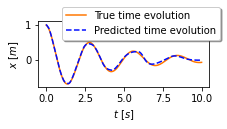

In [27]:
pendulum_prediction(net_2, 0.5, 5.);

In [28]:
%matplotlib tk
osc_representation_plot(net_2, [0.5, 1], [5, 10]);

(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1, 1) (1, 1)
(1, 50) (1